# Multivariate linear regression

Multivariate linear regression on simulated data

Our model is:

$$\mathbf{Y} = \mathbf{X}\mathbf{B} + \mathbf{E}$$

where $\mathbf{Y}$ (dependent variables we want to predict, outcomes) and $\mathbf{E}$ (gaussian error $\mathcal{N}(0,\Sigma)$) are $(N_{obs}, M)$ matrices, $\mathbf{X}$ (dependent variable/predictors/explanatory variables) is a $(N_{obs}, N)$ matrix and $\mathbf{B}$ (parameters we will try to infer) is a $(N, M)$ matrix.

# PyStan code

In [1]:
import pystan
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("multivariate_data.csv").set_index(["category","number"])
X = data.loc["x"].values.T
Y = data.loc["y"].values.T
N_obs, N = X.shape
M = Y.shape[1]

In [3]:
multivariate_lr_code = """
data {
    int<lower=1> M;     // num of outcomes
    int<lower=1> N;     // num of explanatory variables
    int<lower=0> N_obs; // num of obs

    vector[N] x[N_obs];     
    vector[M] y[N_obs];     
}
parameters {
    matrix[N, M] B;     
    cov_matrix[M] Sigma;
}

transformed parameters {
    vector[M] mu[N_obs];
  
    for (n in 1:N_obs){
        mu[n] = transpose(B) * x[n];
    }
}

model {

    y ~ multi_normal(mu, Sigma);
    
}

generated quantities {
    vector[N_obs] log_lik;
    vector[M] y_hat[N_obs];
    
    for (n in 1:N_obs){
        log_lik[n] = multi_normal_lpdf(y[n] | mu[n], Sigma);
    }
    
    y_hat = multi_normal_rng(mu, Sigma);
}
"""

In [4]:
multivariate_lr_dat = {
    'N': N,
    'M': M,
    'N_obs': N_obs,
    'y': Y,
    'x': X,
}

sm = pystan.StanModel(model_code=multivariate_lr_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13230a6f3c60d41c088298b1584d36ac NOW.


In [5]:
fit = sm.sampling(
    data=multivariate_lr_dat, 
    iter=3000, 
    chains=8, 
    control={"max_treedepth":15, "adapt_delta":.85}, 
    pars=["B", "Sigma", "y_hat", "log_lik"])

In [6]:
dims = {"y":["N_obs", "M"], 
        "x":["N_obs","N"], 
        "B": ["N", "M"], 
        "Sigma": ["M1", "M2"], 
        "y_hat": ["N_obs", "M"], 
        "log_lik":["N_obs"]}
coords = {"N_obs":range(N_obs),"N":range(N), "M": range(M), "M1": range(M), "M2": range(M)}
idata = az.from_pystan(
    posterior=fit,
    observed_data=['y', 'x'],
    posterior_predictive="y_hat",
    log_likelihood="log_lik",
    coords=coords,
    dims=dims
)

In [7]:
az.summary(idata, var_names=["Sigma"])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"Sigma[0,0]",52.155,172.968,3.475,2.457,2.713,142.338,2478.0,2478.0,1494.0,1767.0,1.01
"Sigma[0,1]",12.386,52.283,0.765,0.541,-26.640,58.796,4673.0,4673.0,1787.0,2268.0,1.01
"Sigma[0,2]",-34.402,174.478,2.660,1.881,-113.966,37.255,4302.0,4302.0,696.0,135.0,1.01
"Sigma[0,3]",17.436,70.422,1.259,0.890,-16.747,61.967,3128.0,3128.0,3081.0,1874.0,1.01
"Sigma[0,4]",19.221,69.551,1.304,0.922,-19.031,79.634,2844.0,2844.0,1058.0,245.0,1.01
"Sigma[1,0]",12.386,52.283,0.765,0.541,-26.640,58.796,4673.0,4673.0,1787.0,2268.0,1.01
"Sigma[1,1]",20.101,52.623,2.009,1.421,1.086,66.890,686.0,686.0,650.0,123.0,1.01
"Sigma[1,2]",2.271,57.701,1.532,1.083,-58.622,61.903,1419.0,1419.0,819.0,119.0,1.01
"Sigma[1,3]",-3.659,25.138,0.383,0.271,-29.639,17.291,4315.0,4315.0,1156.0,286.0,1.01
"Sigma[1,4]",3.911,40.466,0.433,0.306,-23.488,33.724,8741.0,8741.0,4269.0,2583.0,1.00


In [8]:
idata.to_netcdf("multivariate_LR_pystan.nc")

'multivariate_LR_pystan.nc'

## Compare results to real parameters

In [9]:
data = pd.read_csv("multivariate_real_params.csv").set_index(["category","number"])
B = data.loc["b"].values
Sigma = data.loc["sigma"].values  

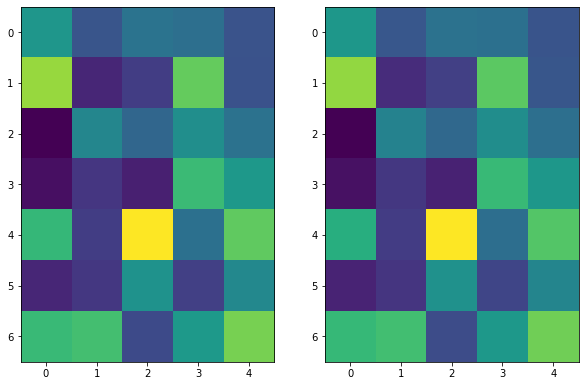

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,7))
axes[0].imshow(B)
B_hat = np.median(idata.posterior.B.values.reshape((-1,N,M)),axis=0)
axes[1].imshow(B_hat)

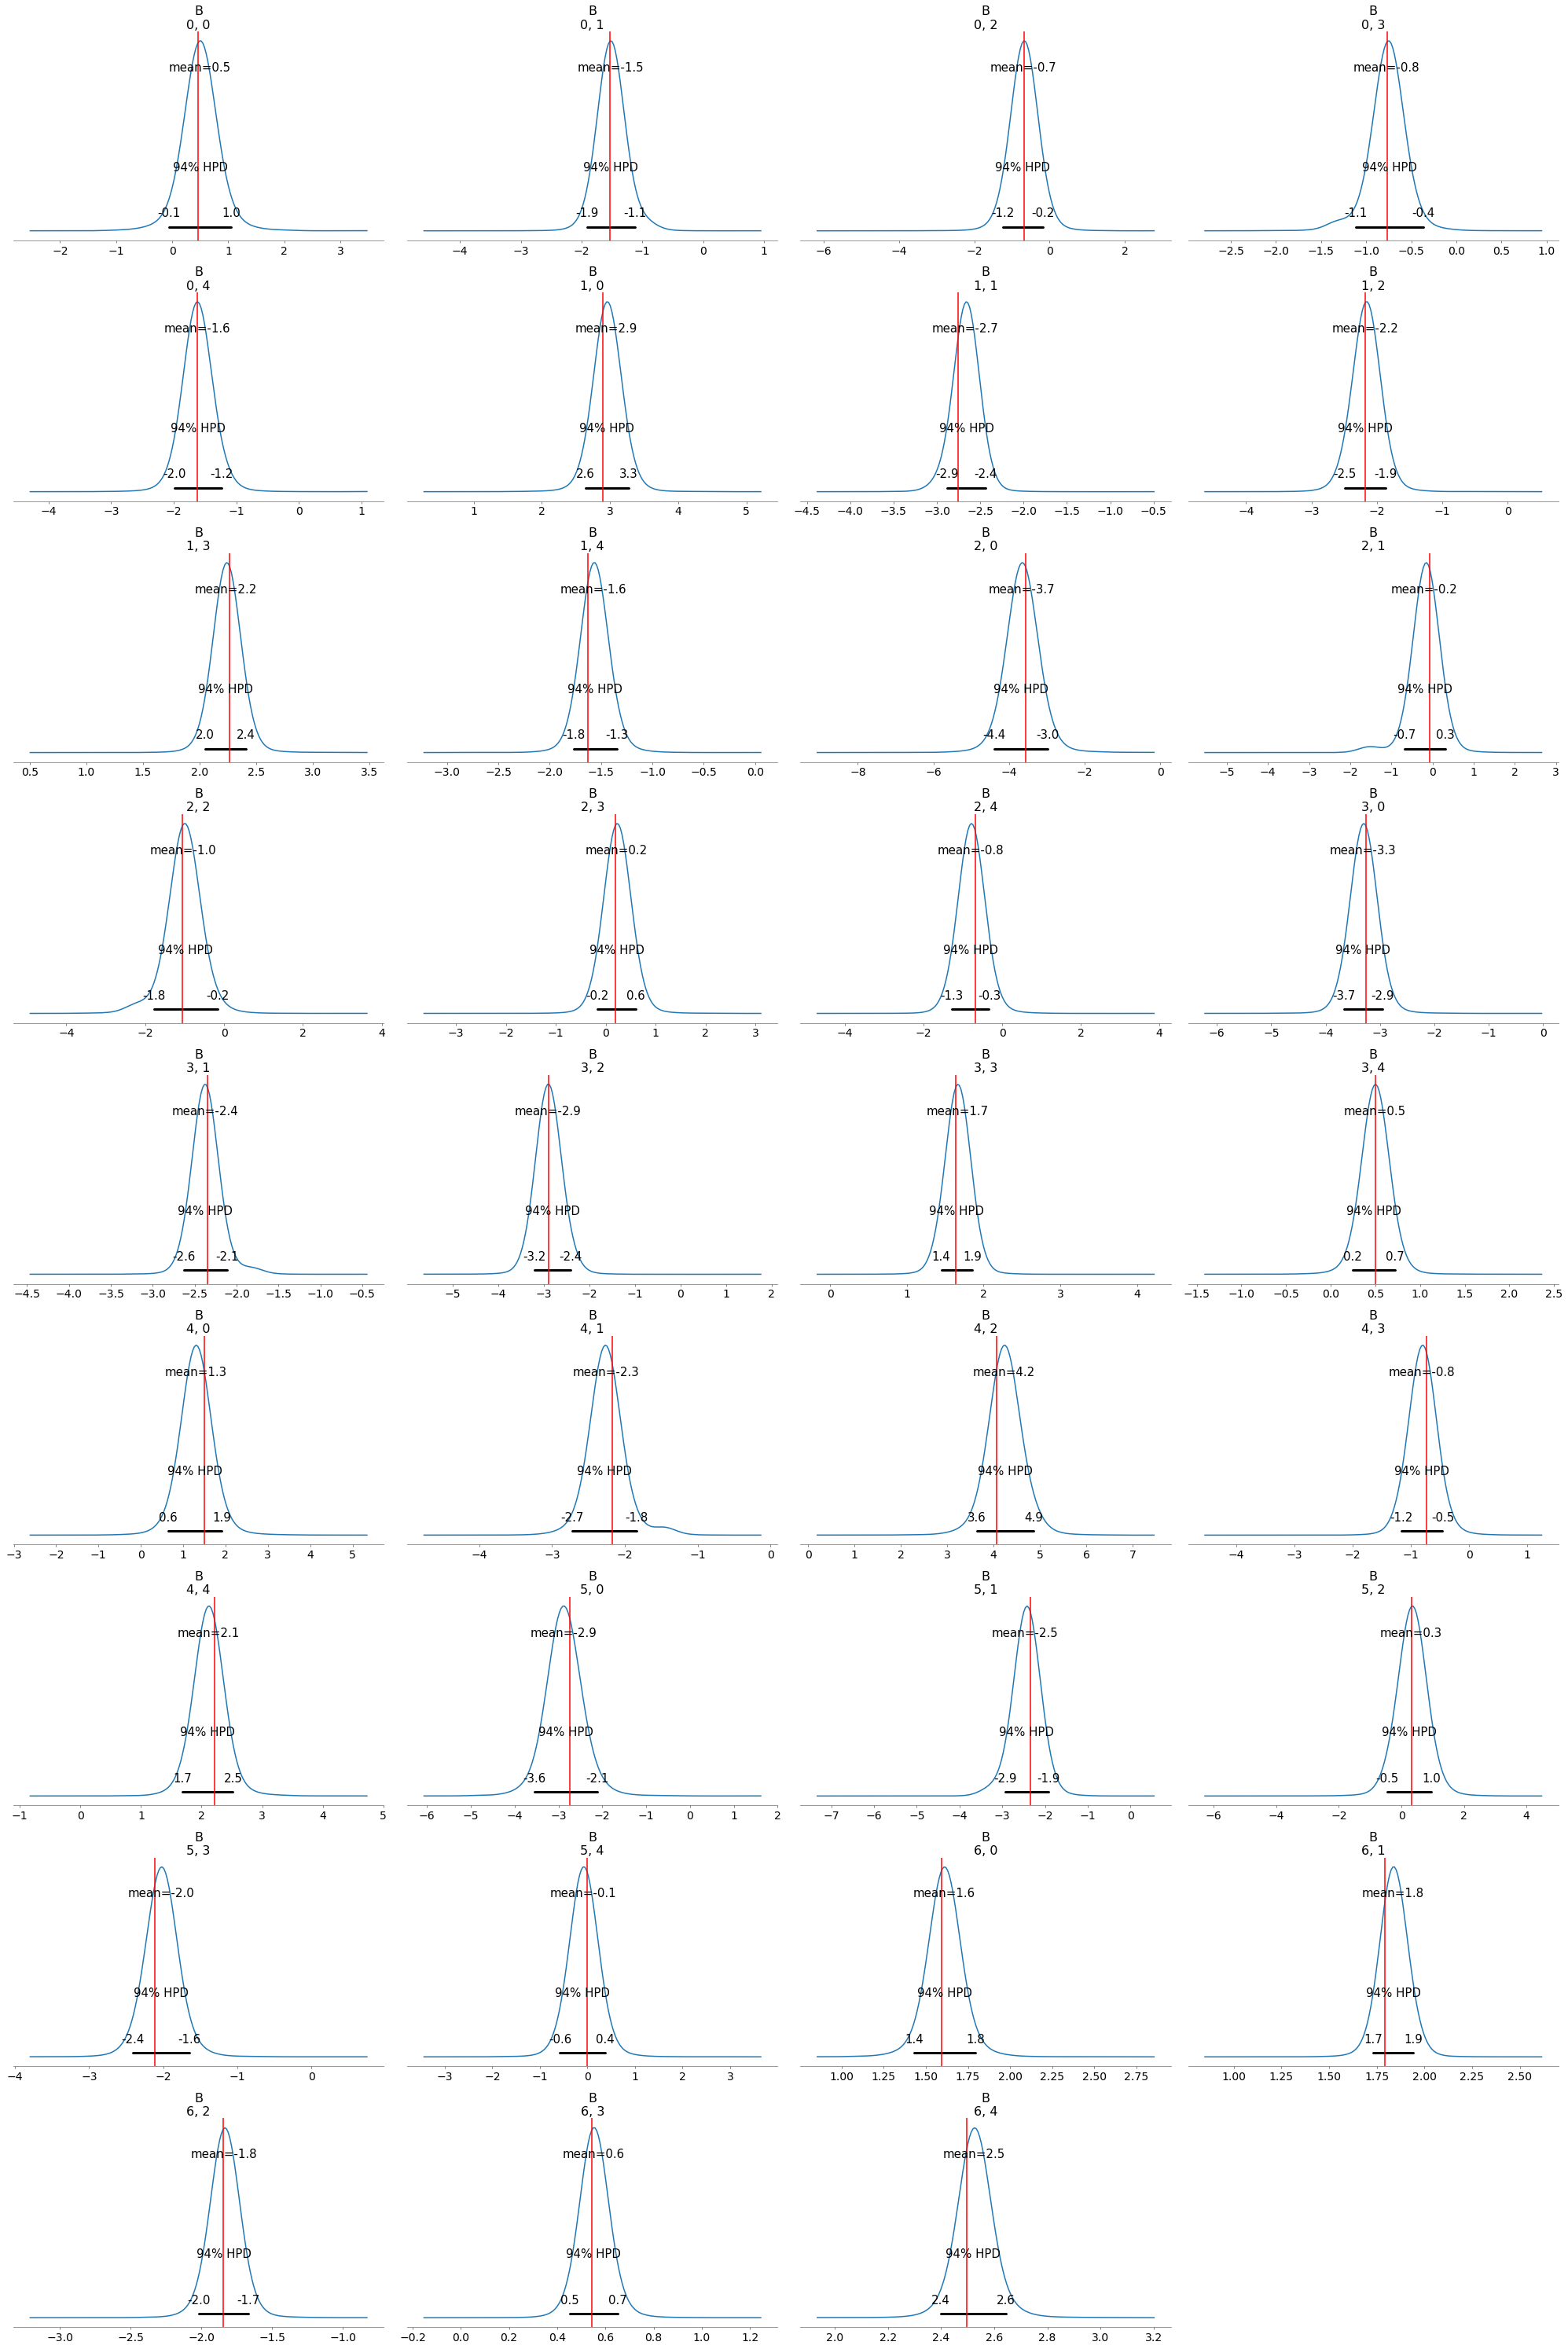

In [11]:
axes = az.plot_posterior(idata, var_names=["B"]);
for ax, truth in zip(axes.flatten(),B.flatten()):
    ax.axvline(truth,color="r")

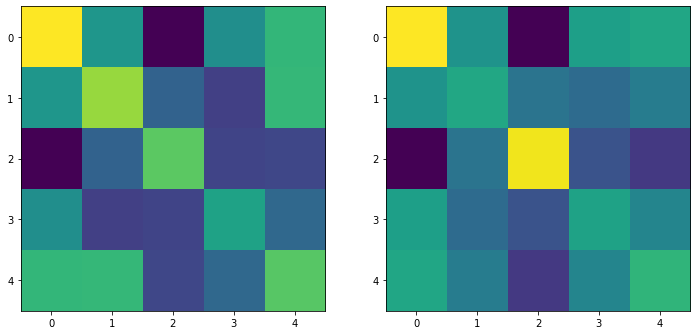

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,7))
axes[0].imshow(Sigma)
Sigma_hat = np.median(idata.posterior.Sigma.values.reshape((-1,M,M)),axis=0)
axes[1].imshow(Sigma_hat)

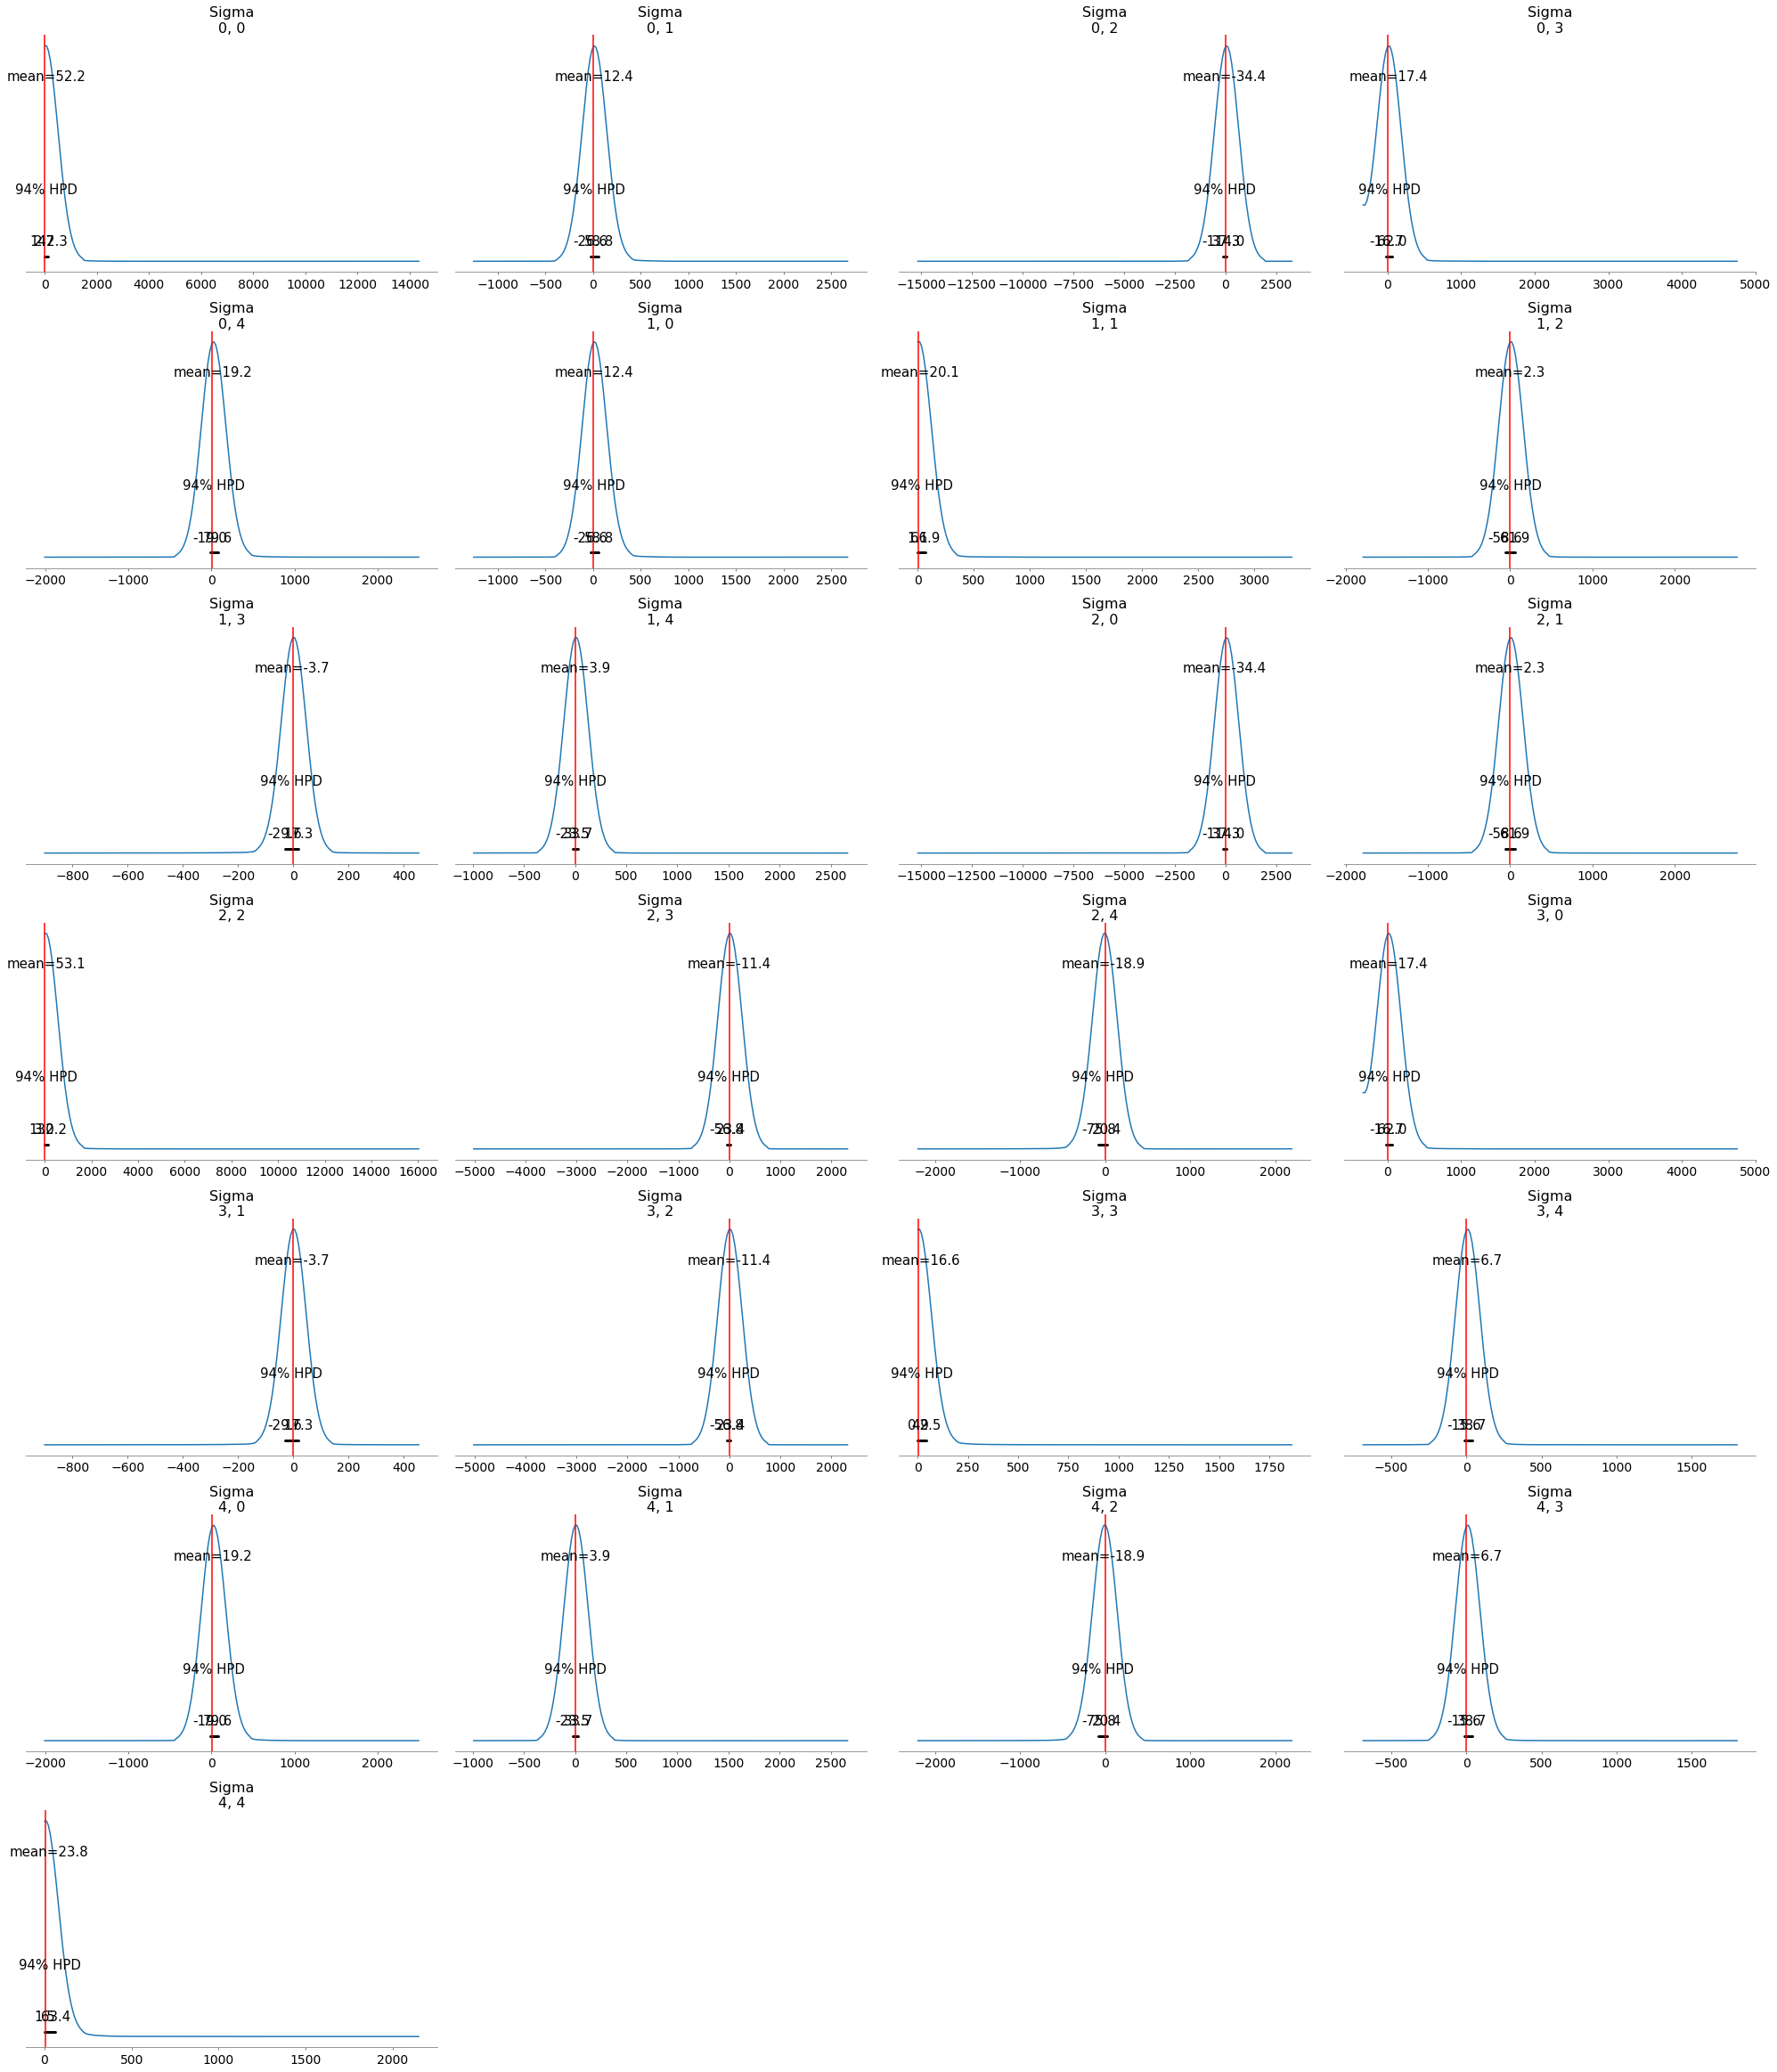

In [13]:
axes = az.plot_posterior(idata, var_names=["Sigma"]);
for ax, truth in zip(axes.flatten(),Sigma.flatten()):
    ax.axvline(truth,color="r")